#  Spatial Clustering

> [`IPYNB`](../content/part2/07_spatial_clustering.ipynb)

> **NOTE**: much of this material has been ported and adapted from "Lab 8" in [Arribas-Bel (2016)](http://darribas.org/gds15).

This notebook covers a brief introduction to spatial regression. To demonstrate this, we will use a dataset of all the AirBnb listings in the city of Austin (check the Data section for more information about the dataset).

Many questions and topics are complex phenomena that involve several dimensions and are hard to summarize into a single variable. In statistical terms, we call this family of problems *multivariate*, as oposed to *univariate* cases where only a single variable is considered in the analysis. Clustering tackles this kind of questions by reducing their dimensionality -the number of relevant variables the analyst needs to look at- and converting it into a more intuitive set of classes that even non-technical audiences can look at and make sense of. For this reason, it is widely use in applied contexts such as policymaking or marketing. In addition, since these methods do not require many preliminar assumptions about the structure of the data, it is a commonly used exploratory tool, as it can quickly give clues about the shape, form and content of a dataset.

The core idea of statistical clustering is to summarize the information contained in several variables by creating a relatively small number of categories. Each observation in the dataset is then assigned to one, and only one, category depending on its values for the variables originally considered in the classification. If done correctly, the exercise reduces the complexity of a multi-dimensional problem while retaining all the meaningful information contained in the original dataset. This is because, once classified, the analyst only needs to look at in which category every observation falls into, instead of considering the multiple values associated with each of the variables and trying to figure out how to put them together in a coherent sense. When the clustering is performed on observations that represent areas, the technique is often called geodemographic analysis.

The basic premise of the exercises we will be doing in this notebook is that, through the characteristics of the houses listed in AirBnb, we can learn about the geography of Austin. In particular, we will try to classify the city's zipcodes into a small number of groups that will allow us to extract some patterns about the main kinds of houses and areas in the city.

## Data

Before anything, let us load up the libraries we will use:

In [2]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysal as ps
import geopandas as gpd
from sklearn import cluster
from sklearn.preprocessing import scale

sns.set(style="whitegrid")

Let us also set the paths to all the files we will need throughout the tutorial:

In [3]:
# Adjust this to point to the right file in your computer
abb_link = '../data/listings.csv.gz'
zc_link = '../data/Zipcodes.geojson'

Before anything, let us load the main dataset:

In [4]:
lst = pd.read_csv(abb_link)

Originally, this is provided at the individual level. Since we will be working in terms of neighborhoods and areas, we will need to aggregate them to that level. For this illustration, we will be using the following subset of variables:

In [5]:
varis = ['bedrooms', 'bathrooms', 'beds']

This will allow us to capture the main elements that describe the "look and feel" of a property and, by aggregation, of an area or neighborhood. All of the variables above are numerical values, so a sensible way to aggregate them is by obtaining the average (of bedrooms, etc.) per zipcode.

In [6]:
aves = lst.groupby('zipcode')[varis].mean()
aves.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 47 entries, 33558.0 to 78759.0
Data columns (total 3 columns):
bedrooms     47 non-null float64
bathrooms    47 non-null float64
beds         47 non-null float64
dtypes: float64(3)
memory usage: 1.5 KB


In addition to these variables, it would be good to include also a sense of what proportions of different types of houses each zipcode has. For example, one can imagine that neighborhoods with a higher proportion of condos than single-family homes will probably look and feel more urban. To do this, we need to do some data munging:

In [7]:
types = pd.get_dummies(lst['property_type'])
prop_types = types.join(lst['zipcode'])\
                  .groupby('zipcode')\
                  .sum()
prop_types_pct = (prop_types * 100.).div(prop_types.sum(axis=1), axis=0)
prop_types_pct.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 47 entries, 33558.0 to 78759.0
Data columns (total 18 columns):
Apartment          47 non-null float64
Bed & Breakfast    47 non-null float64
Boat               47 non-null float64
Bungalow           47 non-null float64
Cabin              47 non-null float64
Camper/RV          47 non-null float64
Chalet             47 non-null float64
Condominium        47 non-null float64
Earth House        47 non-null float64
House              47 non-null float64
Hut                47 non-null float64
Loft               47 non-null float64
Other              47 non-null float64
Tent               47 non-null float64
Tipi               47 non-null float64
Townhouse          47 non-null float64
Treehouse          47 non-null float64
Villa              47 non-null float64
dtypes: float64(18)
memory usage: 7.0 KB


Now we bring both sets of variables together:

In [8]:
aves_props = aves.join(prop_types_pct)

And since we will be feeding this into the clustering algorithm, we will first standardize the columns:

In [9]:
db = pd.DataFrame(\
                 scale(aves_props), \
                 index=aves_props.index, \
                 columns=aves_props.columns)\
       .rename(lambda x: str(int(x)))

Now let us bring geography in:

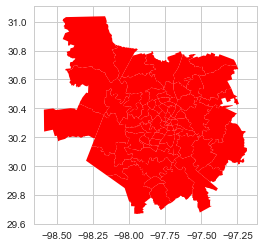

In [10]:
zc = gpd.read_file(zc_link)
zc.plot(color='red');

And combine the two:

In [11]:
zdb = zc[['geometry', 'zipcode', 'name']].join(db, on='zipcode')\
                                         .dropna()

To get a sense of which areas we have lost:

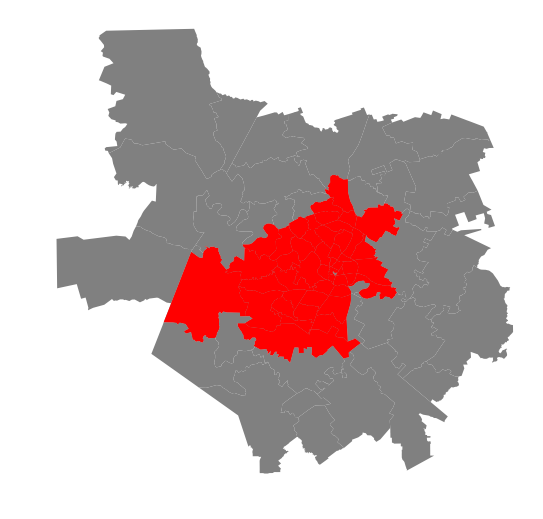

In [12]:
f, ax = plt.subplots(1, figsize=(9, 9))

zc.plot(color='grey', linewidth=0, ax=ax)
zdb.plot(color='red', linewidth=0.1, ax=ax)

ax.set_axis_off()

plt.show()

## Geodemographic analysis

The main intuition behind geodemographic analysis is to group disparate areas of a city or region into a small set of classes that capture several characteristics shared by those in the same group. By doing this, we can get a new perspective not only on the types of areas in a city, but on how they are distributed over space. In the context of our AirBnb data analysis, the idea is that we can group different zipcodes of Austin based on the type of houses listed on the website. This will give us a hint into the geography of AirBnb in the Texan tech capital.

Although there exist many techniques to statistically group observations in a dataset, all of them are based on the premise of using a set of attributes to define classes or categories of observations that are similar *within* each of them, but differ *between* groups. How similarity within groups and dissimilarity between them is defined and how the classification algorithm is operationalized is what makes techniques differ and also what makes each of them particularly well suited for specific problems or types of data. As an illustration, we will only dip our toes into one of these methods, K-means, which is probably the most commonly used technique for statistical clustering.

Technically speaking, we describe the method and the parameters on the following line of code, where we specifically ask for five groups:

In [13]:
cluster.KMeans?

In [14]:
km5 = cluster.KMeans(n_clusters=5)

Following the `sklearn` pipeline approach, all the heavy-lifting of the clustering happens when we `fit` the model to the data:

In [15]:
km5cls = km5.fit(zdb.drop(['geometry', 'name'], axis=1).values)

Now we can extract the classes and put them on a map:

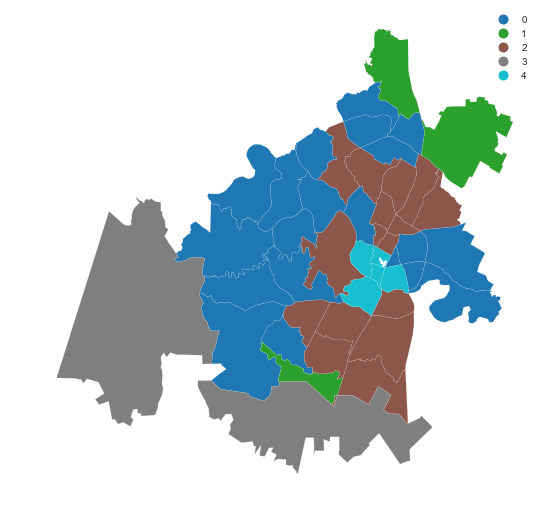

In [16]:
f, ax = plt.subplots(1, figsize=(9, 9))

zdb.assign(cl=km5cls.labels_)\
   .plot(column='cl', categorical=True, legend=True, \
         linewidth=0.1, edgecolor='white', ax=ax)

ax.set_axis_off()

plt.show()

The map above shows a clear pattern: there is a class at the core of the city (number 0, in red), then two other ones in a sort of "urban ring" (number 1 and 3, in green and brown, respectively), and two peripheral sets of areas (number 2 and 4, yellow and green).

This gives us a good insight into the geographical structure, but does not tell us much about what are the defining elements of these groups. To do that, we can have a peak into the characteristics of the classes. For example, let us look at how the proportion of different types of properties are distributed across clusters:

In [17]:
cl_pcts = prop_types_pct.rename(lambda x: str(int(x)))\
                          .reindex(zdb['zipcode'])\
                          .assign(cl=km5cls.labels_)\
                          .groupby('cl')\
                          .mean()

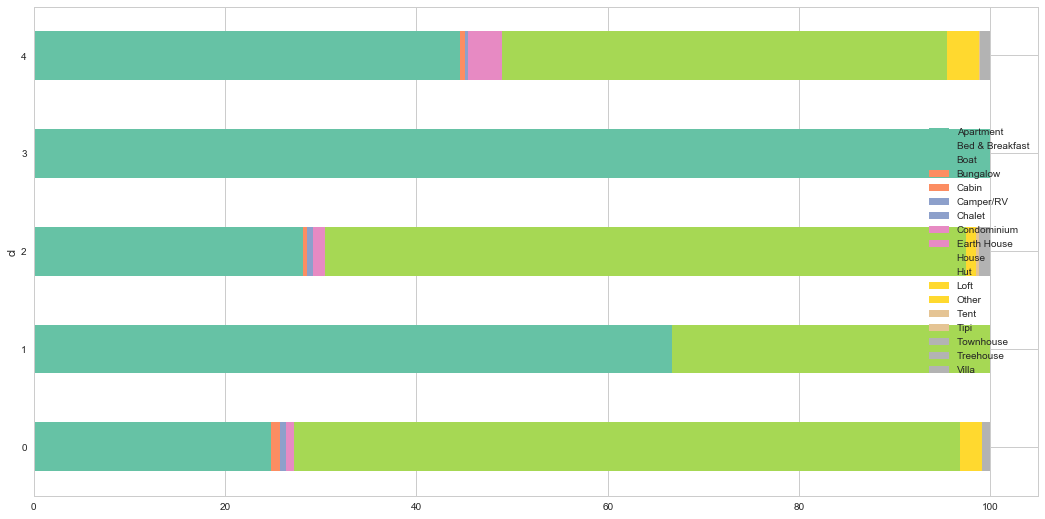

In [18]:
f, ax = plt.subplots(1, figsize=(18, 9))
cl_pcts.plot(kind='barh', stacked=True, ax=ax, \
             cmap='Set2', linewidth=0)
ax.legend(ncol=1, loc="right");

A few interesting, albeit maybe not completely unsurprising, characteristics stand out. First, most of the locations we have in the dataset are either apartments or houses. However, how they are distributed is interesting. The urban core -cluster 0- distinctively has the highest proportion of condos and lofts. The suburban ring -clusters 1 and 3- is very consistent, with a large share of houses and less apartments, particularly so in the case of cluster 3. Class 4 has only two types of properties, houses and apartments, suggesting there are not that many places listed at AirBnb. Finally, class 3 arises as a more rural and leisure one: beyond apartments, it has a large share of bed & breakfasts.

**Mini Exercise**

> *What are the average number of beds, bedrooms and bathrooms for every class?*

## Regionalization analysis: building (meaningful) regions

In the case of analysing spatial data, there is a subset of methods that are of particular interest for many common cases in Geographic Data Science. These are the so-called regionalization techniques. Regionalization methods can take also many forms and faces but, at their core, they all involve statistical clustering of observations with the additional constraint that observations need to be geographical neighbors to be in the same category. Because of this, rather than category, we will use the term area for each observation and region for each class or cluster -hence regionalization, the construction of regions from smaller areas.

As in the non-spatial case, there are many different algorithms to perform regionalization, and they all differ on details relating to the way they measure (dis)similarity, the process to regionalize, etc. However, same as above too, they all share a few common aspects. In particular, they all take a set of input attributes *and* a representation of space in the form of a binary spatial weights matrix. Depending on the algorithm, they also require the desired number of output regions into which the areas are aggregated.

In this example, we are going to create aggregations of zipcodes into groups that have areas where the AirBnb listed location have similar ratings. In other words, we will create delineations for the "quality" or "satisfaction" of AirBnb users. In other words, we will explore what are the boundaries that separate areas where AirBnb users tend to be satisfied about their experience versus those where the ratings are not as high. To do this, we will focus on the `review_scores_X` set of variables in the original dataset:

In [19]:
ratings = [i for i in lst if 'review_scores_' in i]
ratings

['review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value']

Similarly to the case above, we now bring this at the zipcode level. Note that, since they are all scores that range from 0 to 100, we can use averages and we do not need to standardize.

In [20]:
rt_av = lst.groupby('zipcode')[ratings]\
           .mean()\
           .rename(lambda x: str(int(x)))

And we link these to the geometries of zipcodes:

In [22]:
zrt = zc[['geometry', 'zipcode']].join(rt_av, on='zipcode')\
                                 .dropna()
zrt.head()

,geometry,zipcode,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,(POLYGON ((-97.63657664958002 30.4026577780347...,78754,89.500000,8.875000,9.00,9.625000,9.37500,8.500000,9.250000
2,(POLYGON ((-97.89001573769271 30.2094119733396...,78739,99.750000,9.750000,10.00,10.000000,10.00000,10.000000,10.000000
4,(POLYGON ((-97.87302802996035 30.4380637200422...,78732,92.000000,9.416667,9.50,9.500000,9.75000,9.833333,9.416667
5,(POLYGON ((-98.01875589320069 30.2416650359924...,78737,97.166667,9.583333,9.75,9.916667,10.00000,9.750000,9.583333
6,(POLYGON ((-97.72792246181841 30.3290554493485...,78756,95.462963,9.703704,9.50,9.962963,9.87037,9.611111,9.518519


In contrast to the standard clustering techniques, regionalization requires a formal representation of topology. This is so the algorithm can impose spatial constraints during the process of clustering the observations. We will use exactly the same approach as in the previous sections of this tutorial for this and build spatial weights objects `W` with `PySAL`. For the sake of this illustration, we will consider queen contiguity, but any other rule should work fine as long as there is a rational behind it. Weights constructors currently only work from shapefiles on disk, so we will write our `GeoDataFrame` first, then create the `W` object, and remove the files.

In [24]:
zrt.to_file('tmp')
w = ps.queen_from_shapefile('tmp/tmp.shp', idVariable='zipcode')
# NOTE: this might not work on Windows
! rm -r tmp
w

Now we are ready to run the regionalization algorithm. In this case we will use the `max-p` ([Duque, Anselin & Rey, 2012)](http://onlinelibrary.wiley.com/doi/10.1111/j.1467-9787.2011.00743.x/abstract), which does not require a predefined number of output regions but instead it takes a target variable that you want to make sure a minimum threshold is met. In our case, since it is based on ratings, we will impose that every resulting region has at least 10% of the total number of reviews. Let us work through what that would mean:

In [25]:
n_rev = lst.groupby('zipcode')\
           .sum()\
           ['number_of_reviews']\
           .rename(lambda x: str(int(x)))\
           .reindex(zrt['zipcode'])
thr = np.round(0.1 * n_rev.sum())
thr

6271.0

This means we want every resulting region to be based on at least 6,271 reviews. Now we have all the pieces, let us glue them together through the algorithm:

In [27]:
# Set the seed for reproducibility
np.random.seed(1234)

z = zrt.drop(['geometry', 'zipcode'], axis=1).values
maxp = ps.region.Maxp(w, z, thr, n_rev.values[:, None], initial=1000)

We can check whether the solution is better (lower within sum of squares) than we would have gotten from a purely random regionalization process using the [`cinference`](http://pysal.readthedocs.io/en/latest/library/region/maxp.html#pysal.region.maxp.Maxp.cinference) method:

In [28]:
%%time
np.random.seed(1234)
maxp.cinference(nperm=999)

Wall time: 22.5 s


Which allows us to obtain an empirical p-value:

In [29]:
maxp.cpvalue

0.029

Which gives us reasonably good confidence that the solution we obtain is more meaningful than pure chance. 

With that out of the way, let us see what the result looks like on a map! First we extract the labels:

In [30]:
lbls = pd.Series(maxp.area2region).reindex(zrt['zipcode'])

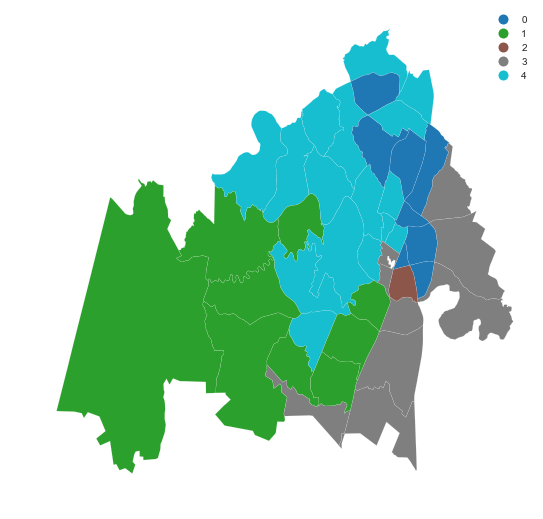

In [31]:
f, ax = plt.subplots(1, figsize=(9, 9))

zrt.assign(cl=lbls.values)\
   .plot(column='cl', categorical=True, legend=True, \
         linewidth=0.1, edgecolor='white', ax=ax)

ax.set_axis_off()

plt.show()

The map shows a clear geographical pattern with a western area, another in the North and a smaller one in the East. Let us unpack what each of them is made of:

In [34]:
zrt[ratings].groupby(lbls.values).mean().T

,0,1,2,3,4
review_scores_rating,94.852751,97.019303,95.612245,92.148673,95.621952
review_scores_accuracy,9.601666,9.797222,9.660883,9.528941,9.581713
review_scores_cleanliness,9.522642,9.679567,9.542587,8.944002,9.576300
review_scores_checkin,9.737999,9.944698,9.856467,9.761440,9.855893
review_scores_communication,9.787118,9.955543,9.851501,9.782700,9.859147
review_scores_location,9.228254,9.667011,9.220472,8.976159,9.590156
review_scores_value,9.501920,9.711037,9.362776,9.482552,9.540474


Although very similar, there are some patterns to be extracted. For example, the East area seems to have lower overall scores.

## Exercise

> *Obtain a geodemographic classification with eight classes instead of five and replicate the analysis above*

> *Re-run the regionalization exercise imposing a minimum of 5% reviews per area*